In [36]:
import pywt
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, MaxPooling2D
import timeit
from keras.utils import to_categorical

# Data load and visualization

Load the MNIST dataset (handwritten digits from 0 to 9). It's separated into train (60000 images) and test (10000 images).

In [45]:
random.seed(666)

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

As the images are already in grey scale and all have the same dimensions the only preprocessing we need to do is convert the pixel values to the range[0.01, 1] in order to avoid divisions by 0.

In [46]:
fac = 0.99/255

X_train = np.asfarray(x_train[:,:]) * fac + 0.01
X_test = np.asfarray(x_test[:,:]) * fac + 0.01

Now we can visualize some of the images.

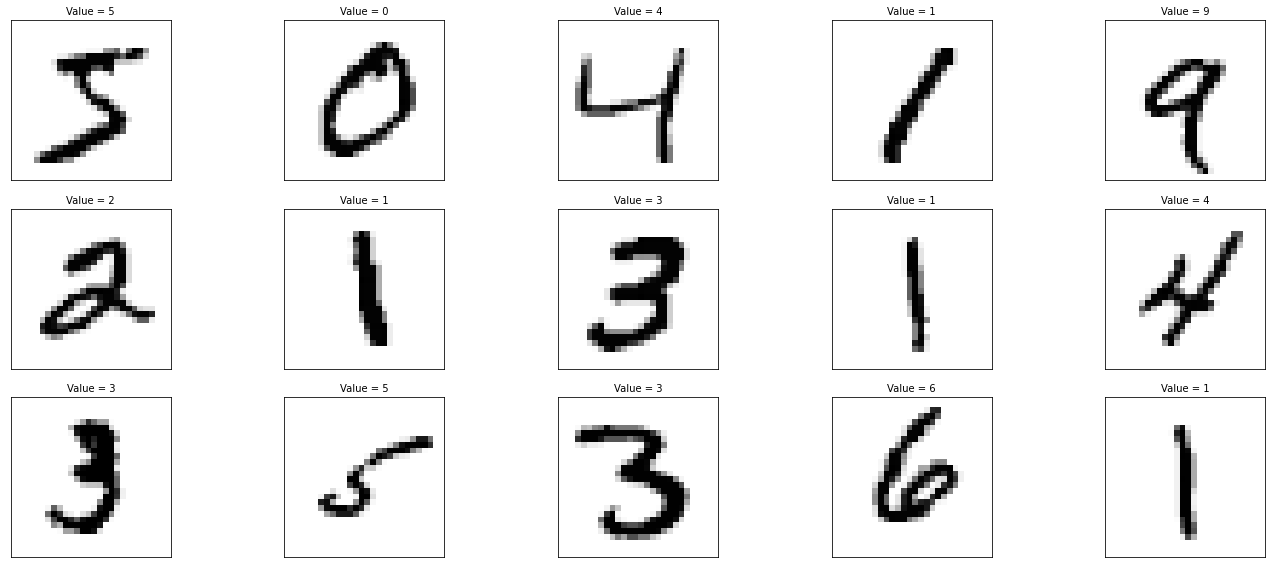

In [100]:
fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(X_train[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Value = ' + str(y_train[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

# Convolutional neural network with original images

We did the classification with the original images with a convolutional neural network. First we specify that there is only one chanel and convert the real values to vectors.

In [48]:
X_train_conv = X_train.reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1], 1)
X_test_conv = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 1)

y_train_conv = to_categorical(y_train)
y_test_conv = to_categorical(y_test)

In [7]:
model = Sequential()
model.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (X_train[0].shape), padding = 'valid'))
model.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(Flatten())
model.add(Dense(10, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          1

Train the model.

In [9]:
start = timeit.default_timer()
model.fit(X_train_conv, y_train_conv, epochs = 50, batch_size = 128, validation_split = 0.3)
stop = timeit.default_timer()
print('Time to train the model: ', stop - start) 

Epoch 1/50
329/329 [==============================] - 49s 58ms/step - loss: 0.6296 - accuracy: 0.7831 - val_loss: 0.2587 - val_accuracy: 0.9756
Epoch 2/50
329/329 [==============================] - 18s 54ms/step - loss: 0.0657 - accuracy: 0.9801 - val_loss: 0.0715 - val_accuracy: 0.9777
Epoch 3/50
329/329 [==============================] - 18s 54ms/step - loss: 0.0426 - accuracy: 0.9863 - val_loss: 0.0684 - val_accuracy: 0.9797
Epoch 4/50
329/329 [==============================] - 18s 54ms/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 0.0514 - val_accuracy: 0.9852
Epoch 5/50
329/329 [==============================] - 18s 54ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0471 - val_accuracy: 0.9880
Epoch 6/50
329/329 [==============================] - 18s 54ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0643 - val_accuracy: 0.9833
Epoch 7/50
329/329 [==============================] - 18s 54ms/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0640 - val_accuracy:

We see the accuracy of the model.

In [67]:
acc = model.evaluate(X_test_conv, y_test_conv)
print(acc[1]*100)

313/313 [==============================] - 2s 7ms/step - loss: 0.0533 - accuracy: 0.9922
99.22000169754028


Get the predictions and plot the confusion matrix.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


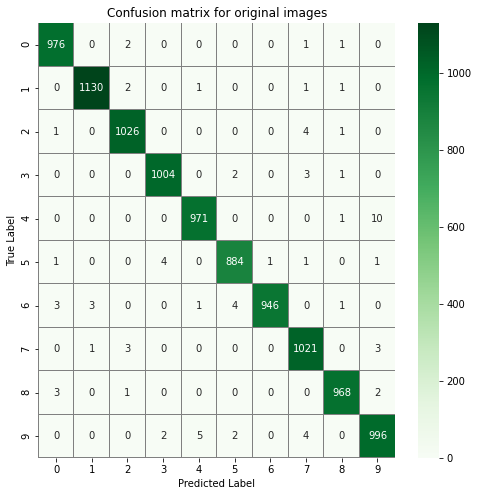

In [42]:
preds = model.predict_classes(X_test_conv)

f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_matrix(y_test, preds), annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.0f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix for original images")
plt.show()

## Errors

We can visualize some of the errors of the model.

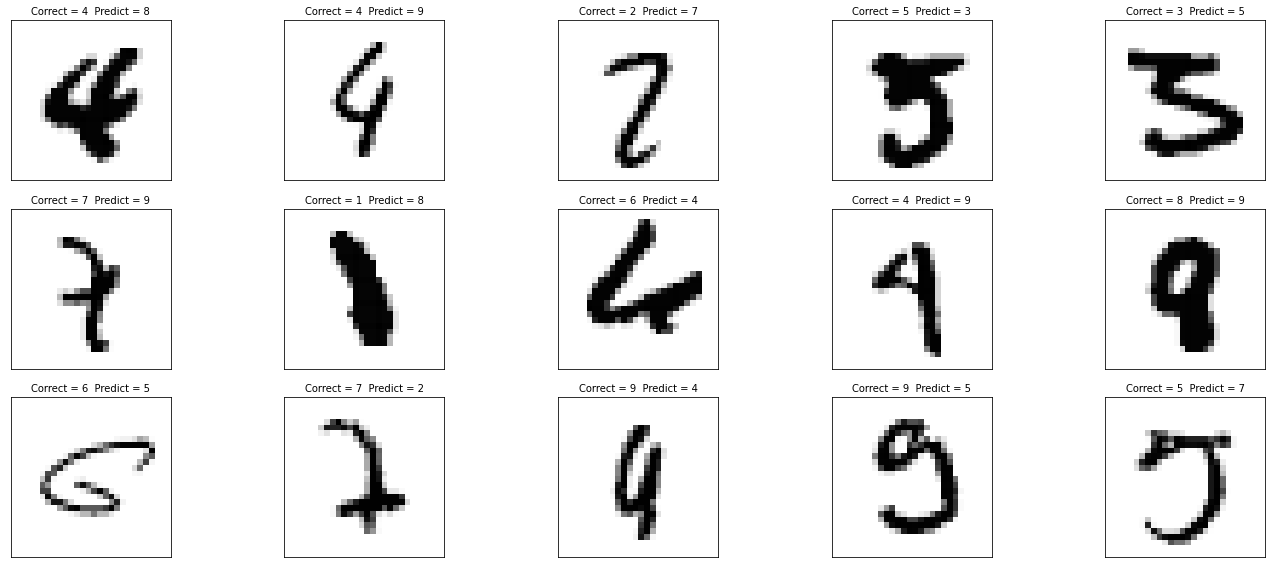

In [101]:
errors = y_test != preds
img_errors= X_test[errors,:]
correct_labels = y_test[errors]
incorrect_labels = preds[errors]

fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(img_errors[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Correct = ' + str(correct_labels[i]) + '  Predict = ' + str(incorrect_labels[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

# Wavelet transform

First we will work with the Haar wavelet. We will do and example for the first image of the dataset and then we will aply the method to all the images. As it is known, in the wavelet tranformation of first order we obtain 4 images (of half size of the original image: 28 x 28 -> 14 x 14): the aproximation image and the horizontal, vertical and diagonal detail images.

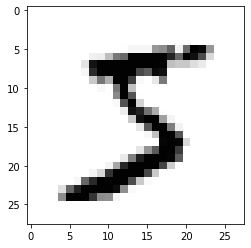

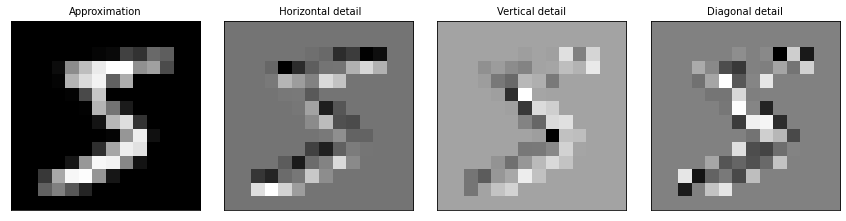

In [49]:
plt.imshow(X_train[0], cmap = "Greys")
plt.show()

titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(X_train[0], 'haar', 'periodization')
LL0, (LH0, HL0, HH0) = coeffs2

fig = plt.figure(figsize = (12, 3))
for i, a in enumerate([LL0, LH0, HL0, HH0]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation = "nearest", cmap = plt.cm.gray)
    ax.set_title(titles[i], fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

Now we do it for all the images from test and train.

In [52]:
LL_train = []
LL_test = []

for img in X_train:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_train.append(LLi)
    
for img in X_test:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_test.append(LLi)

## Convolutional neural network with first level wavelet

We train a model but now with the first aproximation images from the wavelet tranformation. As before, first we specify the chanel.

In [59]:
LL_train_conv = np.array(LL_train).reshape(len(LL_train), LL_train[0].shape[0], LL_train[0].shape[1], 1)
LL_test_conv = np.array(LL_test).reshape(len(LL_test), LL_test[0].shape[0], LL_test[0].shape[1], 1)

In [61]:
model_1 = Sequential()
model_1.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (LL_train_conv[0].shape), padding = 'valid'))
model_1.add(Conv2D(128, kernel_size = 3, activation = 'relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model_1.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model_1.add(Flatten())
model_1.add(Dense(10, activation = 'relu'))
model_1.add(Dense(100, activation = 'relu'))
model_1.add(Dense(10, activation = 'softmax'))

model_1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [62]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 12, 12, 128)       1280      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 128)       512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          73792     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1, 32)         

Train the model.

In [63]:
start = timeit.default_timer()
model_1.fit(LL_train_conv, y_train_conv, epochs = 50, batch_size = 128, validation_split = 0.3)
stop = timeit.default_timer()
print('Time to train the model: ', stop - start) 

Epoch 1/50
329/329 [==============================] - 6s 16ms/step - loss: 0.5895 - accuracy: 0.7924 - val_loss: 0.2135 - val_accuracy: 0.9785
Epoch 2/50
329/329 [==============================] - 5s 15ms/step - loss: 0.0653 - accuracy: 0.9807 - val_loss: 0.0636 - val_accuracy: 0.9823
Epoch 3/50
329/329 [==============================] - 5s 15ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.0733 - val_accuracy: 0.9804
Epoch 4/50
329/329 [==============================] - 5s 15ms/step - loss: 0.0288 - accuracy: 0.9906 - val_loss: 0.0524 - val_accuracy: 0.9851
Epoch 5/50
329/329 [==============================] - 5s 15ms/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.0658 - val_accuracy: 0.9837
Epoch 6/50
329/329 [==============================] - 5s 15ms/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0511 - val_accuracy: 0.9861
Epoch 7/50
329/329 [==============================] - 5s 15ms/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0473 - val_accuracy: 0.9870

See the accuracy of the model.

In [68]:
acc_LL = model_1.evaluate(LL_test_conv, y_test_conv)
print(acc_LL[1] * 100)

313/313 [==============================] - 1s 4ms/step - loss: 0.0604 - accuracy: 0.9911
99.1100013256073


Get the predictions and plot the confusion matrix.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


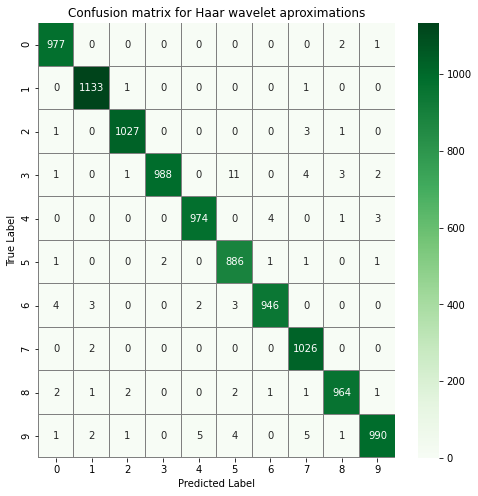

In [70]:
preds_LL = model_1.predict_classes(LL_test_conv)

f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_matrix(y_test, preds_LL), annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.0f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix for Haar wavelet aproximations")
plt.show()

### Errors

We can visualize again some errors of the model.

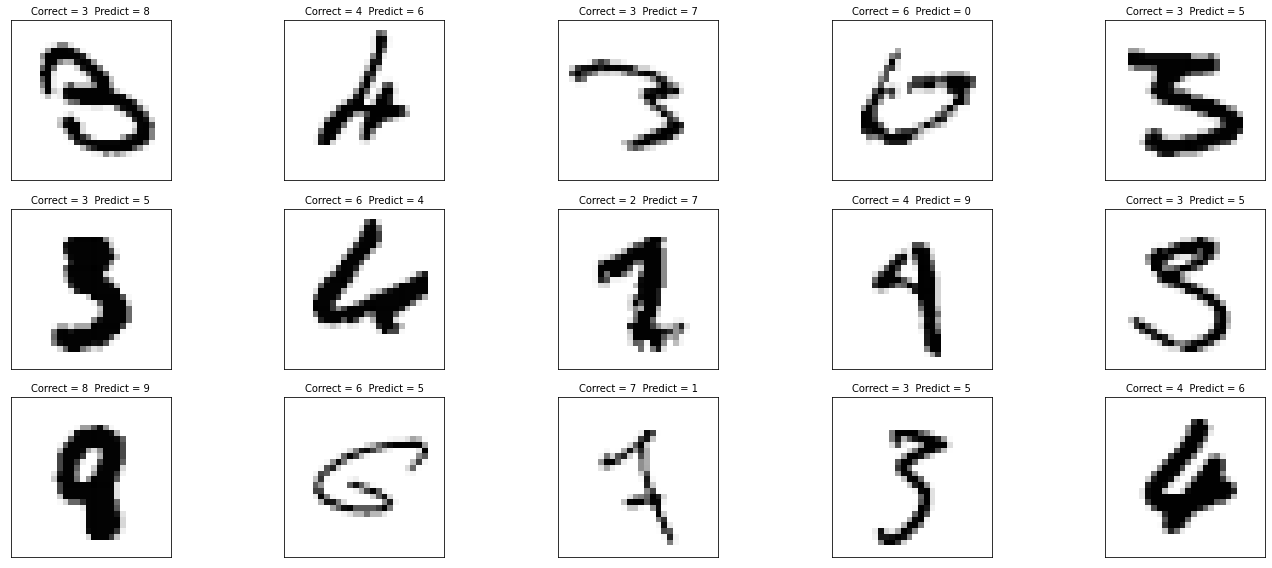

In [103]:
errors_2 = y_test != preds_LL
img_errors_2 = X_test[errors_2,:]
correct_labels_2 = y_test[errors_2]
incorrect_labels_2 = preds_LL[errors_2]

fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(img_errors_2[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Correct = ' + str(correct_labels_2[i]) + '  Predict = ' + str(incorrect_labels_2[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()

# Second level wavelet transformation

Let's do again the wavelet tranformation but now over the aproximation images from the first order transformation. First for one image and after that for all of them. Now the images will have a sahpe of 7 x 7.

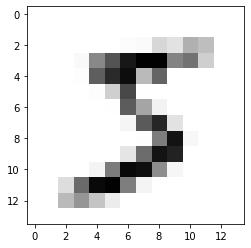

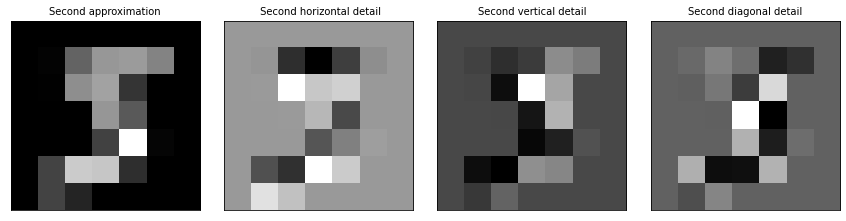

In [74]:
plt.imshow(LL0, cmap = "Greys")
plt.show()

titles = ['Second approximation', ' Second horizontal detail', 'Second vertical detail', 'Second diagonal detail']
coeffs2_2 = pywt.dwt2(LL0, 'haar', 'periodization')
LL0_2, (LH0_2, HL0_2, HH0_2) = coeffs2_2

fig = plt.figure(figsize = (12, 3))
for i, a in enumerate([LL0_2, LH0_2, HL0_2, HH0_2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation = "nearest", cmap = plt.cm.gray)
    ax.set_title(titles[i], fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [75]:
LL_train_2 = []
LL_test_2 = []

for img in LL_train:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_train_2.append(LLi)
    
for img in LL_test:
    LLi, (LHi, HLi, HHi) = pywt.dwt2(img, 'haar', 'periodization')
    LL_test_2.append(LLi)

## Convolutional neural network with second level wavelet

We train a model with the second aproximation images from the second order wavelet tranformation. As before, first we specify the chanel.

In [78]:
LL_train_2_conv = np.array(LL_train_2).reshape(len(LL_train_2), LL_train_2[0].shape[0], LL_train_2[0].shape[1], 1)
LL_test_2_conv = np.array(LL_test_2).reshape(len(LL_test_2), LL_test_2[0].shape[0], LL_test_2[0].shape[1], 1)

In [84]:
model_2 = Sequential()
model_2.add(Conv2D(128, kernel_size = 3, activation = 'relu', input_shape = (LL_train_2_conv[0].shape), padding = 'valid'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation = 'relu'))
model_2.add(Dense(100, activation = 'relu'))
model_2.add(Dense(10, activation = 'softmax'))

model_2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [86]:
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 5, 5, 128)         1280      
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 32)          36896     
_________________________________________________________________
flatten_2 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2890      
_________________________________________________________________
dense_7 (Dense)              (None, 100)              

In [87]:
start = timeit.default_timer()
model_2.fit(LL_train_2_conv, y_train_conv, epochs = 50, batch_size = 128, validation_split = 0.3)
stop = timeit.default_timer()
print('Time to train the model: ', stop - start) 

Epoch 1/50
329/329 [==============================] - 3s 8ms/step - loss: 0.7149 - accuracy: 0.7632 - val_loss: 0.4371 - val_accuracy: 0.9379
Epoch 2/50
329/329 [==============================] - 2s 7ms/step - loss: 0.1880 - accuracy: 0.9405 - val_loss: 0.1755 - val_accuracy: 0.9433
Epoch 3/50
329/329 [==============================] - 2s 7ms/step - loss: 0.1461 - accuracy: 0.9527 - val_loss: 0.1411 - val_accuracy: 0.9562
Epoch 4/50
329/329 [==============================] - 2s 7ms/step - loss: 0.1196 - accuracy: 0.9614 - val_loss: 0.1541 - val_accuracy: 0.9520
Epoch 5/50
329/329 [==============================] - 2s 7ms/step - loss: 0.1152 - accuracy: 0.9625 - val_loss: 0.1297 - val_accuracy: 0.9601
Epoch 6/50
329/329 [==============================] - 2s 7ms/step - loss: 0.1091 - accuracy: 0.9644 - val_loss: 0.1320 - val_accuracy: 0.9589
Epoch 7/50
329/329 [==============================] - 2s 7ms/step - loss: 0.0915 - accuracy: 0.9703 - val_loss: 0.1252 - val_accuracy: 0.9607
Epoch 

See the accuracy of the model.

In [89]:
acc_LL_2 = model_2.evaluate(LL_test_2_conv, y_test_conv)
print(acc_LL_2[1] * 100)

313/313 [==============================] - 1s 3ms/step - loss: 0.1305 - accuracy: 0.9710
97.10000157356262


Get the predictions and plot the confusion matrix.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


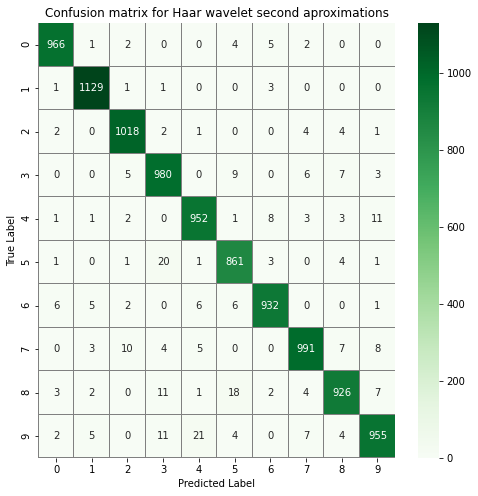

In [90]:
preds_LL_2 = model_2.predict_classes(LL_test_2_conv)

f,ax = plt.subplots(figsize = (8, 8))
sns.heatmap(confusion_matrix(y_test, preds_LL_2), annot = True, linewidths = 0.01, cmap = "Greens", linecolor = "gray", fmt = '.0f', ax = ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix for Haar wavelet second aproximations")
plt.show()

### Errors

We can visualize again some errors of the model.

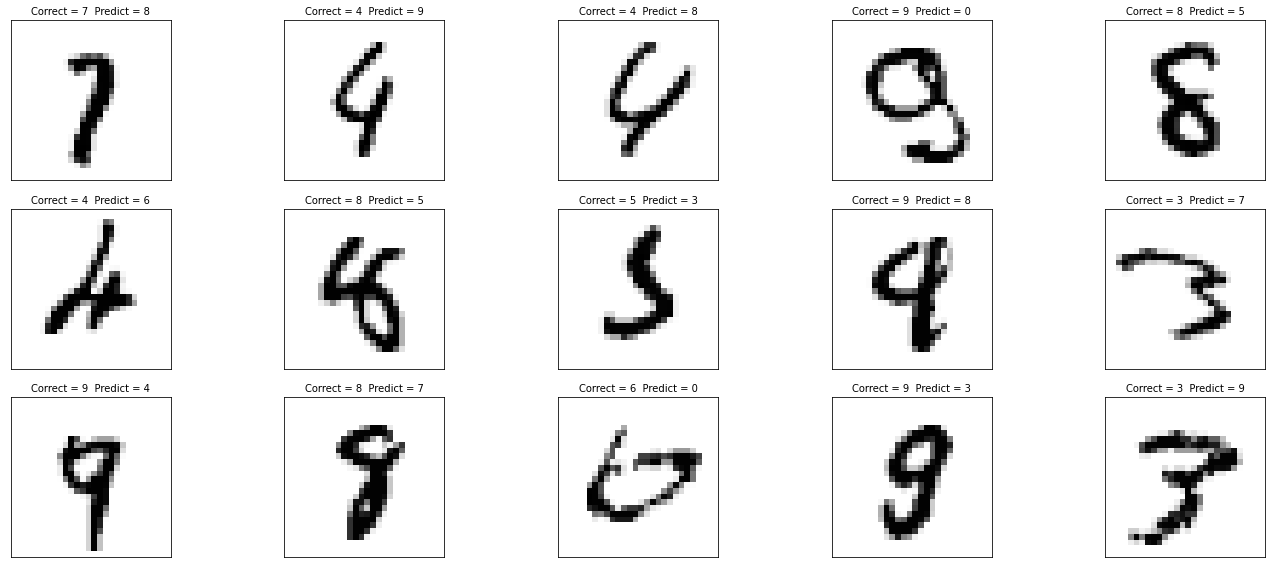

In [104]:
errors_3 = y_test != preds_LL_2
img_errors_3 = X_test[errors_3,:]
correct_labels_3 = y_test[errors_3]
incorrect_labels_3 = preds_LL_2[errors_3]

fig = plt.figure(figsize = (20, 8))

for i, a in enumerate(img_errors_3[:15]):
    ax = fig.add_subplot(3, 5, i + 1)
    ax.imshow(a, cmap = "Greys")
    ax.set_title('Correct = ' + str(correct_labels_3[i]) + '  Predict = ' + str(incorrect_labels_3[i]), fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
plt.show()